In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import scipy.stats as sps
import json, pickle, os, glob, sys
from enterprise.pulsar import Pulsar
import pandas as pd

import enterprise
from enterprise.pulsar import Pulsar

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import la_forge
import la_forge.diagnostics as dg
from la_forge.core import TimingCore
from la_forge.core import Core

In [3]:
color_cycle_wong = ['#000000','#E69F00','#009E73','#56B4E9','#0072B2','#F0E442','#D55E00','#CC79A7']
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle_wong)

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
#top_path_idx = splt_path.index("akaiser")
top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

In [5]:
e_e_path = top_dir + "/enterprise_extensions/"
sys.path.insert(0, e_e_path)
sys.path.insert(0, top_dir + "/enterprise_timing")
sys.path.insert(0, top_dir + "/nano15yr_gwb_scripts")

In [6]:
import enterprise_extensions
from enterprise_extensions import sampler
#from enterprise_extensions.timing import timing_block,tm_delay
import gridding_utils as gu
import mcmc_diagnostics as mcmcd

In [7]:
psr_name = 'J1640+2224'#'J2043+1711'#'J2317+1439' 'J1909-3744'
datarelease = '12p5yr_working'
datadir = (top_dir + f"/enterprise_timing/{psr_name}/Fonseca_PAL2/J1640+2224/m2sini")
parfile = datadir + f"/{psr_name}.working.par"
timfile = datadir + f"/{psr_name}.working.tim"
print("Using {} data".format(datarelease))
ephem = 'DE436'
psr = Pulsar(parfile, timfile, ephem=ephem, clk=None, drop_t2pulsar=False)

Using 12p5yr_working data


In [8]:
grid_param = 'PMELAT'

In [9]:
ltm_list = []
fixed_list = []
nltm_params = []
tm_param_dict = {}
for par in psr.fitpars:
    if par == "Offset":
        ltm_list.append(par)
    elif par == grid_param:
        nltm_params.append(par)
    elif par == "SINI" and "COSI" == grid_param:
        nltm_params.append("COSI")
    elif par == "PBDOT" and par == grid_param:
        pbdot = np.double(psr.t2pulsar.vals()[psr.t2pulsar.pars().index(par)])
        pbdot_sigma = np.double(psr.t2pulsar.errs()[psr.t2pulsar.pars().index(par)])
        print("USING PHYSICAL PBDOT. Val: ", pbdot, "Err: ", pbdot_sigma * 1e-12)
        lower = pbdot - 5 * pbdot_sigma * 1e-12
        upper = pbdot + 5 * pbdot_sigma * 1e-12
        tm_param_dict["PBDOT"] = {
            "prior_lower_bound": lower,
            "prior_upper_bound": upper,
        }
    elif par == "XDOT" and par == grid_param:
        xdot = np.double(psr.t2pulsar.vals()[psr.t2pulsar.pars().index(par)])
        xdot_sigma = np.double(psr.t2pulsar.errs()[psr.t2pulsar.pars().index(par)])
        print("USING PHYSICAL XDOT. Val: ", xdot, "Err: ", xdot_sigma * 1e-12)
        lower = xdot - 5 * xdot_sigma * 1e-12
        upper = xdot + 5 * xdot_sigma * 1e-12
        tm_param_dict["XDOT"] = {
            "prior_lower_bound": lower,
            "prior_upper_bound": upper,
        }
    else:
        fixed_list.append(par)
print('nltm_params:')
print('\t',nltm_params)
print('ltm_list')
print('\t',ltm_list)
print('fixed_list')
print('\t',fixed_list)

nltm_params:
	 ['PMELAT']
ltm_list
	 ['Offset']
fixed_list
	 ['ELONG', 'ELAT', 'F0', 'F1', 'PMELONG', 'PX', 'SINI', 'PB', 'T0', 'A1', 'OM', 'ECC', 'XDOT', 'M2', 'FD1', 'FD2', 'FD3', 'FD4', 'DMX_0001', 'DMX_0002', 'DMX_0003', 'DMX_0004', 'DMX_0005', 'DMX_0006', 'DMX_0007', 'DMX_0008', 'DMX_0009', 'DMX_0010', 'DMX_0011', 'DMX_0012', 'DMX_0013', 'DMX_0014', 'DMX_0015', 'DMX_0016', 'DMX_0017', 'DMX_0018', 'DMX_0019', 'DMX_0020', 'DMX_0021', 'DMX_0022', 'DMX_0023', 'DMX_0024', 'DMX_0025', 'DMX_0026', 'DMX_0027', 'DMX_0028', 'DMX_0029', 'DMX_0030', 'DMX_0031', 'DMX_0032', 'DMX_0033', 'DMX_0034', 'DMX_0035', 'DMX_0036', 'DMX_0037', 'DMX_0038', 'DMX_0039', 'DMX_0040', 'DMX_0041', 'DMX_0042', 'DMX_0043', 'DMX_0044', 'DMX_0045', 'DMX_0046', 'DMX_0047', 'DMX_0048', 'DMX_0049', 'DMX_0050', 'DMX_0051', 'DMX_0052', 'DMX_0053', 'DMX_0054', 'DMX_0055', 'DMX_0056', 'DMX_0057', 'DMX_0058', 'DMX_0059', 'DMX_0060', 'DMX_0061', 'DMX_0062', 'DMX_0063', 'DMX_0064', 'DMX_0065', 'DMX_0066', 'DMX_0067', 'DMX_00

# Loading runs for MLVs

In [10]:
burn=None
PAL2_fonseca_dir = top_dir + f'/enterprise_timing/{psr_name}/Fonseca_PAL2/{psr_name}/m2sini/chains/'
enterprise_equiv_pars = ['J1640+2224_430_ASP_efac','J1640+2224_430_PUPPI_efac',
                         'J1640+2224_L-wide_PUPPI_efac','J1640+2224_L-wide_ASP_efac',
                         'J1640+2224_430_ASP_log10_ecorr','J1640+2224_430_PUPPI_log10_ecorr',
                         'J1640+2224_L-wide_ASP_log10_ecorr','J1640+2224_L-wide_PUPPI_log10_ecorr',
                         'J1640+2224_430_ASP_log10_equad','J1640+2224_430_PUPPI_log10_equad',
                         'J1640+2224_L-wide_PUPPI_log10_equad','J1640+2224_L-wide_ASP_log10_equad',
                         'J1640+2224_timing_model_PMELONG','J1640+2224_timing_model_PMELAT',
                         'J1640+2224_timing_model_PX','J1640+2224_timing_model_SINI',
                         'J1640+2224_timing_model_PB','J1640+2224_timing_model_T0',
                         'J1640+2224_timing_model_A1','J1640+2224_timing_model_OM',
                         'J1640+2224_timing_model_ECC','J1640+2224_timing_model_XDOT',
                         'J1640+2224_timing_model_M2']
PAL2_fonseca_chain = pd.read_csv(PAL2_fonseca_dir+'chain_1.txt', sep='\t', dtype=float, header=None).values
core_PAL2_fonseca = Core('PAL2_fonseca',
                             chain=PAL2_fonseca_chain,
                             params=enterprise_equiv_pars,
                              burn=burn)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 12375
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


In [11]:
def get_titles(core):
    titles = []
    for core_param in core.params:
        if 'timing' in core_param.split('_'):
            if 'DMX' in core_param.split('_'):
                titles.append(('_').join(core_param.split('_')[-2:]))
            else:
                titles.append(core_param.split('_')[-1])
        else:
            if psr_name in core_param.split('_'):
                titles.append((' ').join(core_param.split('_')[1:]))
            else:
                titles.append(core_param)
    """
    else:
        unparams=['lnpost','lnlike','chain_accept','pt_chain_accept']
        for com_par in params:
            if (
                com_par
                not in core.params
            ):
                unparams.append(com_par)
        for ncom_par in unparams:
            if ncom_par in params:
                del titles[params.index(ncom_par)]
                del params[
                    params.index(ncom_par)
                ]
    """
    return titles

In [12]:
#titles_nltm = get_titles(core_DE436_noRN_varyWN_lin_DMX_COSI_1)
titles_F16 = get_titles(core_PAL2_fonseca)

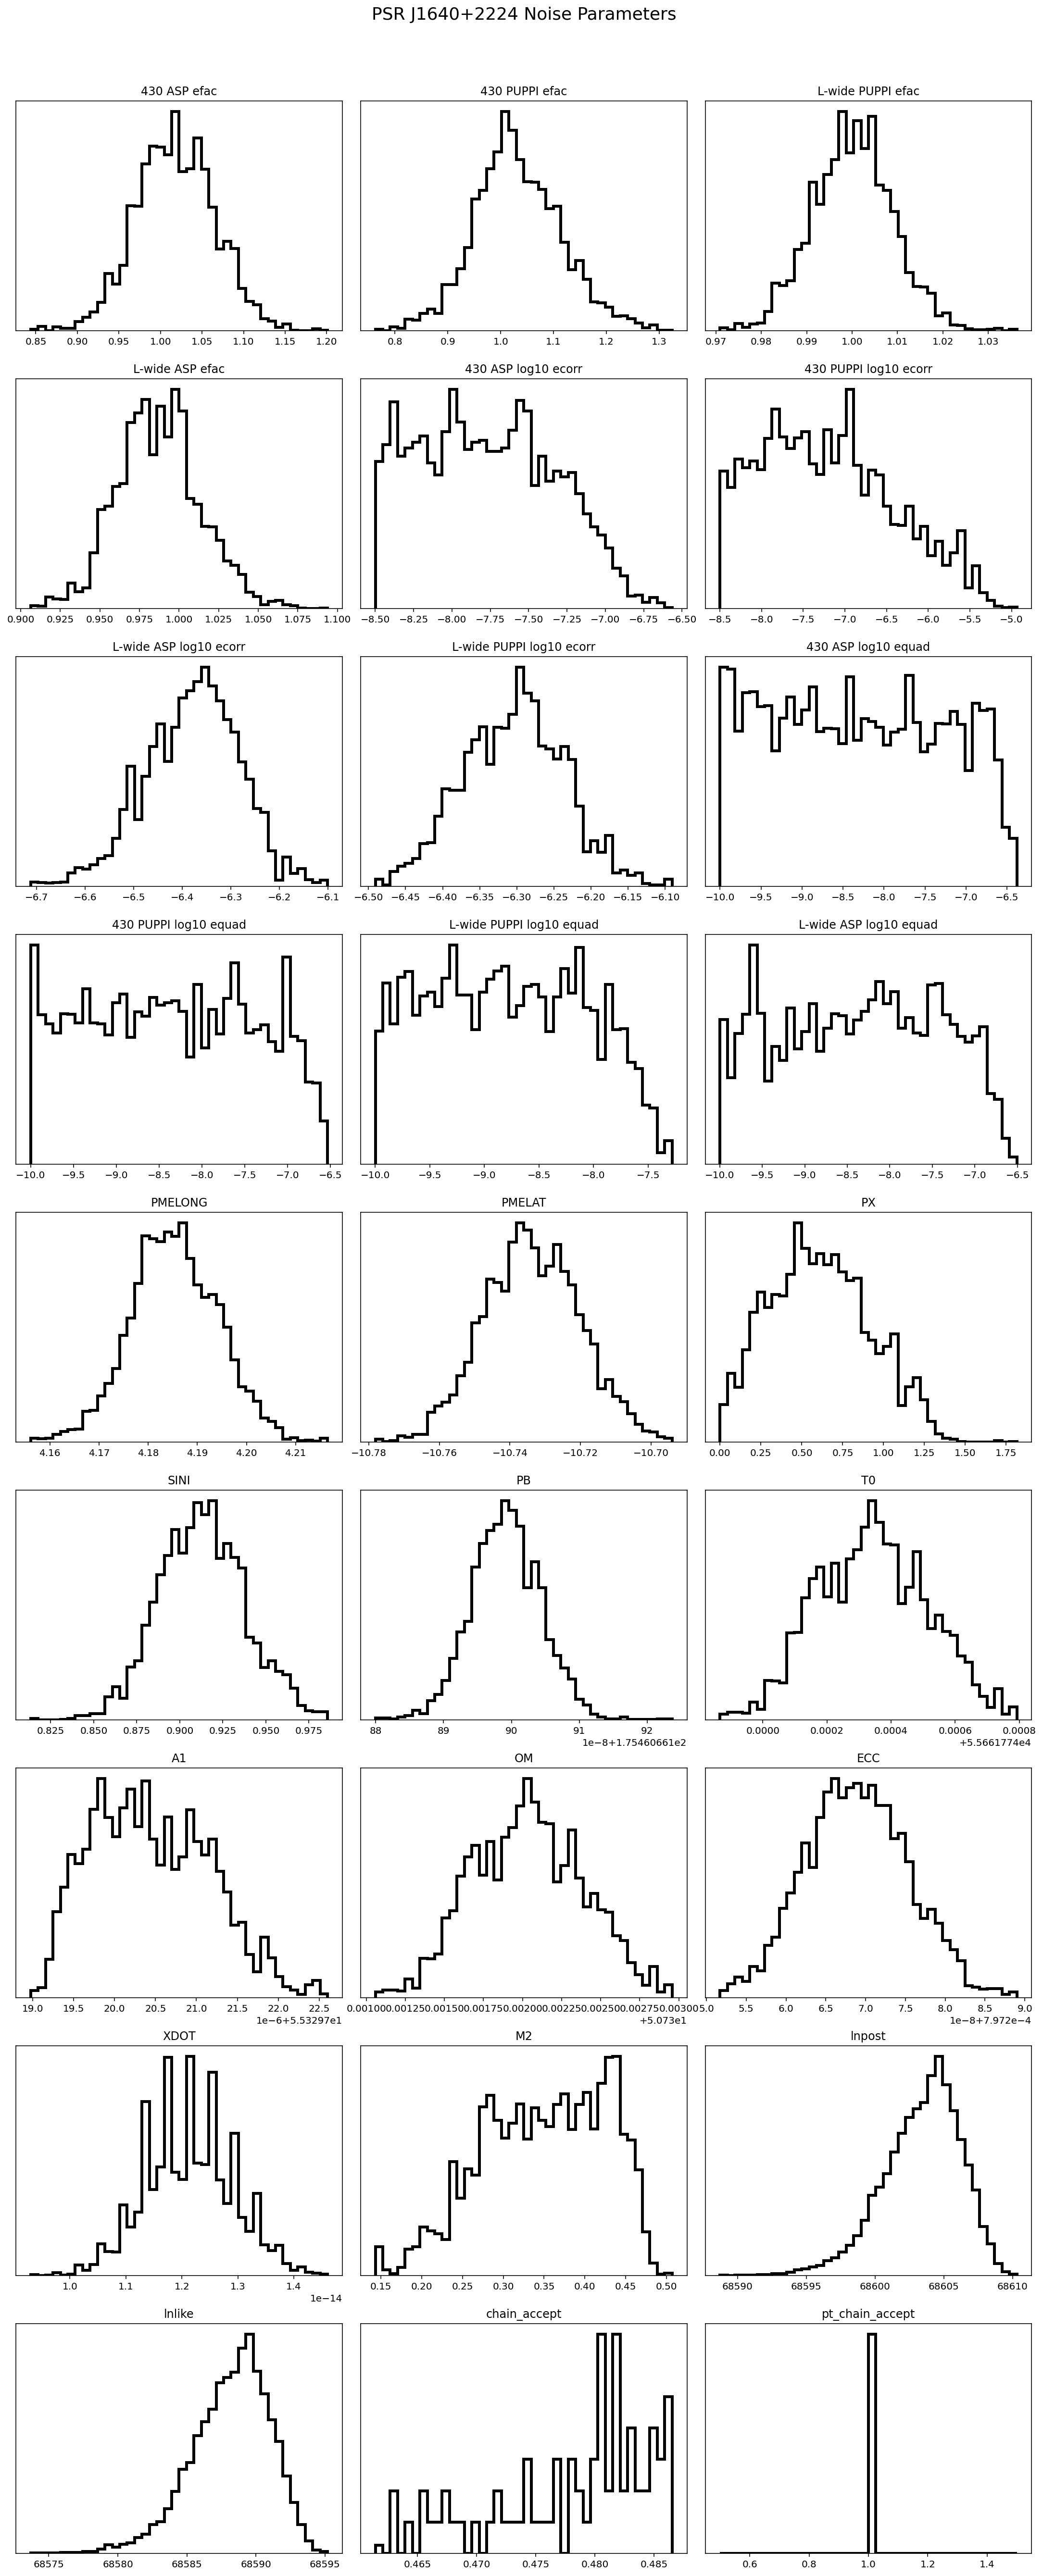

In [13]:
hist_core_kwargs = {'hist':True, 'ncols':3,'title_y':1.03,
                'hist_kwargs':dict(fill=False),'linewidth':3.}
dg.plot_chains(core_PAL2_fonseca,
               pars=core_PAL2_fonseca.params,
               titles=titles_F16,
               real_tm_pars=False,
               **hist_core_kwargs)

In [14]:
mcmcd.grubin(core_PAL2_fonseca.chain)

(array([1.01458407, 1.01284182, 1.00274882, 1.00595135, 1.00287443,
        1.00099796, 1.0174876 , 1.01648671, 1.02146647, 1.01063852,
        1.02693564, 1.003585  , 1.03968422, 1.04242318, 1.01800731,
        1.00469567, 1.01164183, 1.01355051, 1.01898779, 1.01355132,
        1.02529646, 1.01847664, 1.01649262, 1.00831177, 1.009566  ,
        6.77182901]),
 array([25]))

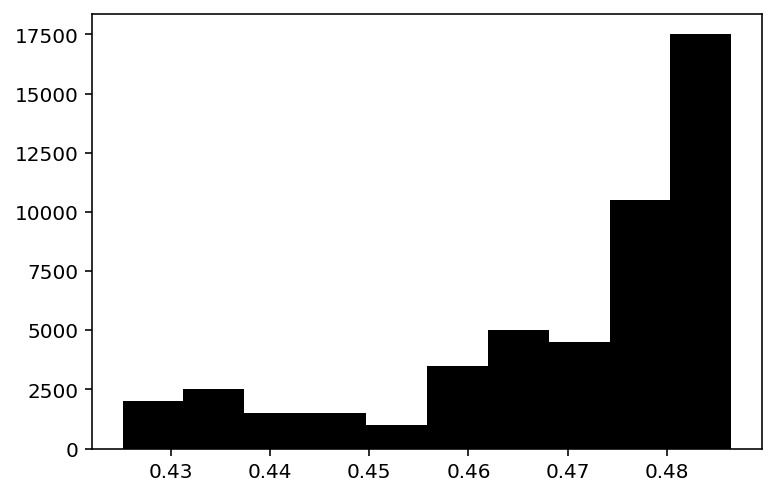

In [15]:
plt.hist(core_PAL2_fonseca.chain[:,25]);

In [16]:
c_F16 = core_PAL2_fonseca
c_F16_titles = get_titles(c_F16)
map_idx_F16 = np.argmax(c_F16.get_param('lnpost',to_burn=True))
map_dict_F16 = {}
tm_param_dict = {}
exclude_list = ['lnpost','lnlike','chain_accept','pt_chain_accept']
noisedict = {}
for par in c_F16.params:
    if grid_param == par.split('_')[-1]:
        unscaled_param = c_F16.get_param(par)
        mean = np.mean(unscaled_param)
        sigma = np.std(unscaled_param)
        lower = mean - 5 * sigma
        upper = mean + 5 * sigma
        tm_param_dict[grid_param] = {
            "prior_lower_bound": lower,
            "prior_upper_bound": upper,
        }
    elif "SINI" in par and grid_param == "COSI":
        unscaled_param = c_F16.get_param(par)
        unscaled_COSI = np.sqrt(1-unscaled_param**2)
        mean = np.mean(unscaled_COSI)
        sigma = np.std(unscaled_COSI)
        lower = mean - 5 * sigma
        upper = mean + 5 * sigma
        tm_param_dict[grid_param] = {
            "prior_lower_bound": lower,
            "prior_upper_bound": upper,
        }
    if par not in exclude_list:
        if 'timing_model' in par:
            unscaled_param = c_F16.get_param(par)
            map_dict_F16[par] = unscaled_param[map_idx_F16]
        else:
            unscaled_param = c_F16.get_param(par)
            noisedict[par] = unscaled_param[map_idx_F16]

In [17]:
print(map_dict_F16)
print('')
print(noisedict)
print('')
print(tm_param_dict)

{'J1640+2224_timing_model_PMELONG': 4.17885496346163, 'J1640+2224_timing_model_PMELAT': -10.734669214940189, 'J1640+2224_timing_model_PX': 0.790742108058695, 'J1640+2224_timing_model_SINI': 0.9010212719777996, 'J1640+2224_timing_model_PB': 175.46066189946055, 'J1640+2224_timing_model_T0': 55661.77428136889, 'J1640+2224_timing_model_A1': 55.32972036996697, 'J1640+2224_timing_model_OM': 50.73190910865213, 'J1640+2224_timing_model_ECC': 0.0007972687644447, 'J1640+2224_timing_model_XDOT': 1.15e-14, 'J1640+2224_timing_model_M2': 0.3697595648851652}

{'J1640+2224_430_ASP_efac': 1.0109568622651295, 'J1640+2224_430_PUPPI_efac': 1.088489092962388, 'J1640+2224_L-wide_PUPPI_efac': 1.0043984840304916, 'J1640+2224_L-wide_ASP_efac': 0.9817089352129924, 'J1640+2224_430_ASP_log10_ecorr': -8.300176241067444, 'J1640+2224_430_PUPPI_log10_ecorr': -6.951392027815206, 'J1640+2224_L-wide_ASP_log10_ecorr': -6.414315116865412, 'J1640+2224_L-wide_PUPPI_log10_ecorr': -6.345105732586531, 'J1640+2224_430_ASP_log10

In [18]:
fit_remaining_pars = False
white_var = False
red_var = False
outdir = current_path + f'/{psr.name}/chains/nltm_gridding/nltm_gridding_{grid_param}'
outdir

'/home/andrew/Documents/Research/nanograv/enterprise_timing/J1640+2224/chains/nltm_gridding/nltm_gridding_PMELAT'

```
noisefiles = sorted(glob.glob(top_dir + "/12p5yr/*.json"))
noisedict = {}
for noisefile in noisefiles:
    tmpnoisedict = {}
    with open(noisefile, "r") as fin:
        tmpnoisedict.update(json.load(fin))
    for key in tmpnoisedict.keys():
        if key.split("_")[0] == psr.name:
            noisedict[key] = tmpnoisedict[key]
print(noisedict)
```

In [19]:
pta = gu.model_nltm(
    psr,
    tm_var=True,
    tm_param_list=nltm_params,
    ltm_list=ltm_list,
    tm_param_dict=tm_param_dict,
    fit_remaining_pars=fit_remaining_pars,
    fixed_dict=map_dict_F16,
    noisedict=noisedict,
    white_vary=white_var,
    red_var = red_var,
)

par: PMELONG parfile val: 4.1827
par: PMELONG fixed val: 4.17885496346163
par: PMELAT parfile val: -10.7322
par: PMELAT fixed val: -10.734669214940189
par: PX parfile val: 0.6607
par: PX fixed val: 0.790742108058695
par: SINI parfile val: 0.84148
par: SINI fixed val: 0.9010212719777996
par: PB parfile val: 175.46066189984214
par: PB fixed val: 175.46066189946055
par: T0 parfile val: 55661.7739622443
par: T0 fixed val: 55661.77428136889
par: A1 parfile val: 55.329717962
par: A1 fixed val: 55.32972036996697
par: OM parfile val: 50.731254177208
par: OM fixed val: 50.73190910865213
par: ECC parfile val: 0.0007972556
par: ECC fixed val: 0.0007972687644447
par: XDOT parfile val: 1.19599999999999997594e-14
par: XDOT fixed val: 1.15e-14
par: M2 parfile val: 0.648043
par: M2 fixed val: 0.3697595648851652


INFO: enterprise.signals.signal_base: Setting J1640+2224_430_ASP_efac to 1.0109568622651295
INFO: enterprise.signals.signal_base: Setting J1640+2224_430_PUPPI_efac to 1.088489092962388
INFO: enterprise.signals.signal_base: Setting J1640+2224_L-wide_ASP_efac to 0.9817089352129924
INFO: enterprise.signals.signal_base: Setting J1640+2224_L-wide_PUPPI_efac to 1.0043984840304916
INFO: enterprise.signals.signal_base: Setting J1640+2224_430_ASP_log10_equad to -9.307469687298717
INFO: enterprise.signals.signal_base: Setting J1640+2224_430_PUPPI_log10_equad to -7.857956718286156
INFO: enterprise.signals.signal_base: Setting J1640+2224_L-wide_ASP_log10_equad to -9.906198465104714
INFO: enterprise.signals.signal_base: Setting J1640+2224_L-wide_PUPPI_log10_equad to -9.511625989306115
INFO: enterprise.signals.signal_base: Setting J1640+2224_430_ASP_log10_ecorr to -8.300176241067444
INFO: enterprise.signals.signal_base: Setting J1640+2224_430_PUPPI_log10_ecorr to -6.951392027815206
INFO: enterprise.

In [20]:
psampler = sampler.setup_sampler(
    pta, outdir=outdir, resume=True, timing=True
)

with open(outdir + "/orig_timing_pars.pkl", "wb") as fout:
    pickle.dump(psr.tm_params_orig, fout)

Adding timing model jump proposal...

Adding timing model prior draw...



In [21]:
x0 = np.hstack([p.sample() for p in pta.params])
N=int(5e4)

In [22]:
psampler.sample(
    x0,
    N,
    SCAMweight=30,
    AMweight=15,
    DEweight=50,
    writeHotChains=False,
    hotChain=False,
)

/home/andrew/anaconda3/envs/enterprise/lib/python3.7/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 20.00 percent in 325.378663 s Acceptance rate = 0.178256Adding DE jump with weight 50
Finished 98.00 percent in 2026.022233 s Acceptance rate = 0.308347
Run Complete


In [28]:
#Finished grid params: 
fin_grid_params = ['COSI','M2','PMELONG','PMELAT']

In [24]:
burn = None
timing_chain = pd.read_csv(outdir+'/chain_1.txt', sep='\t', dtype=float, header=None).values
timing_core = TimingCore(grid_param,chain=timing_chain,params=[grid_param]+exclude_list,
                         tm_pars_path=outdir+'/orig_timing_pars.pkl',
                         burn=burn)

No burn specified. Burn set to 25% of chain length, 1225
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


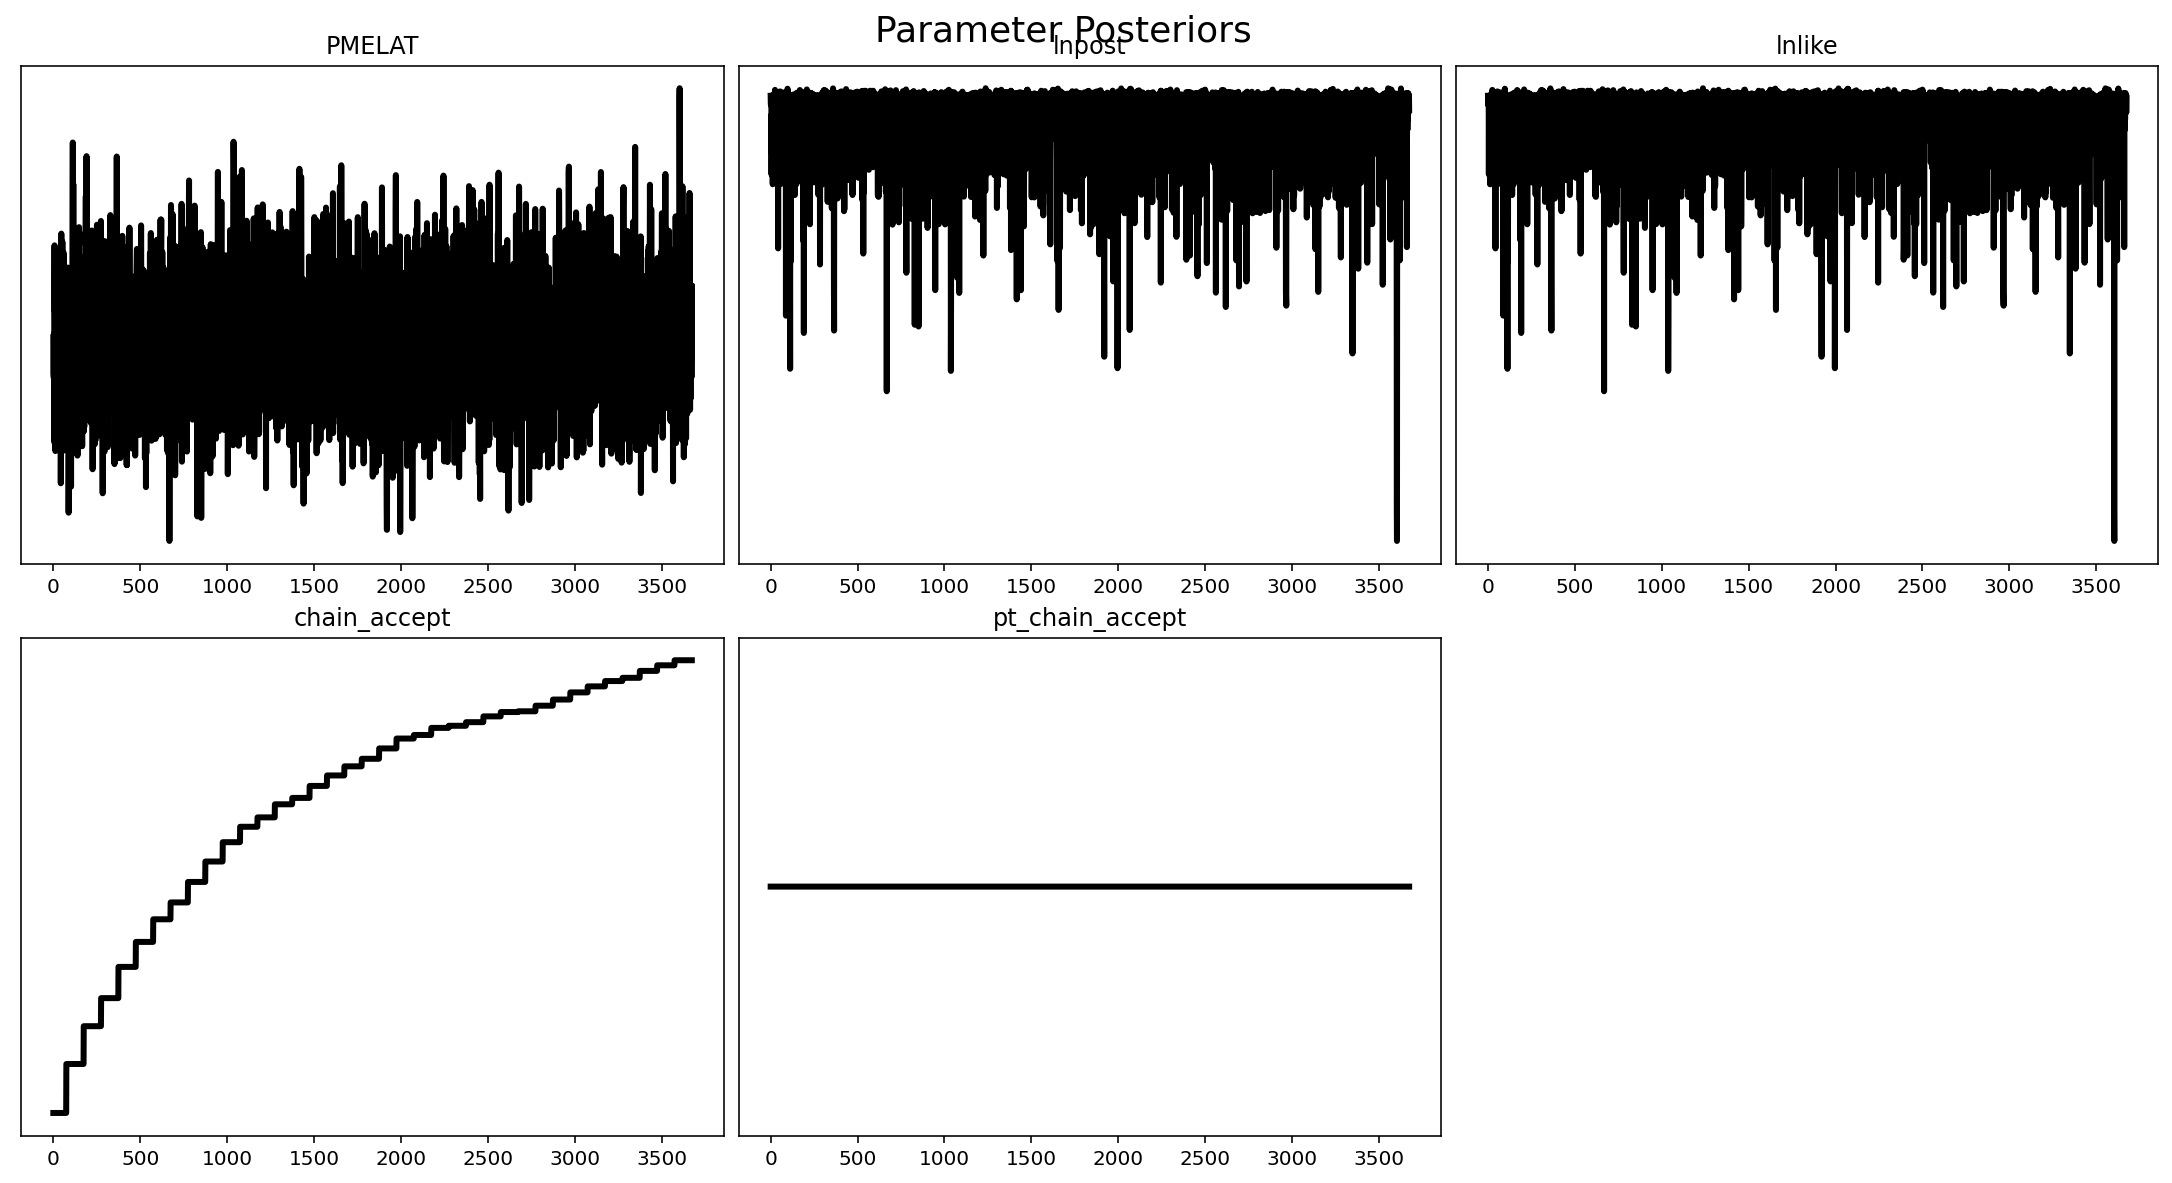

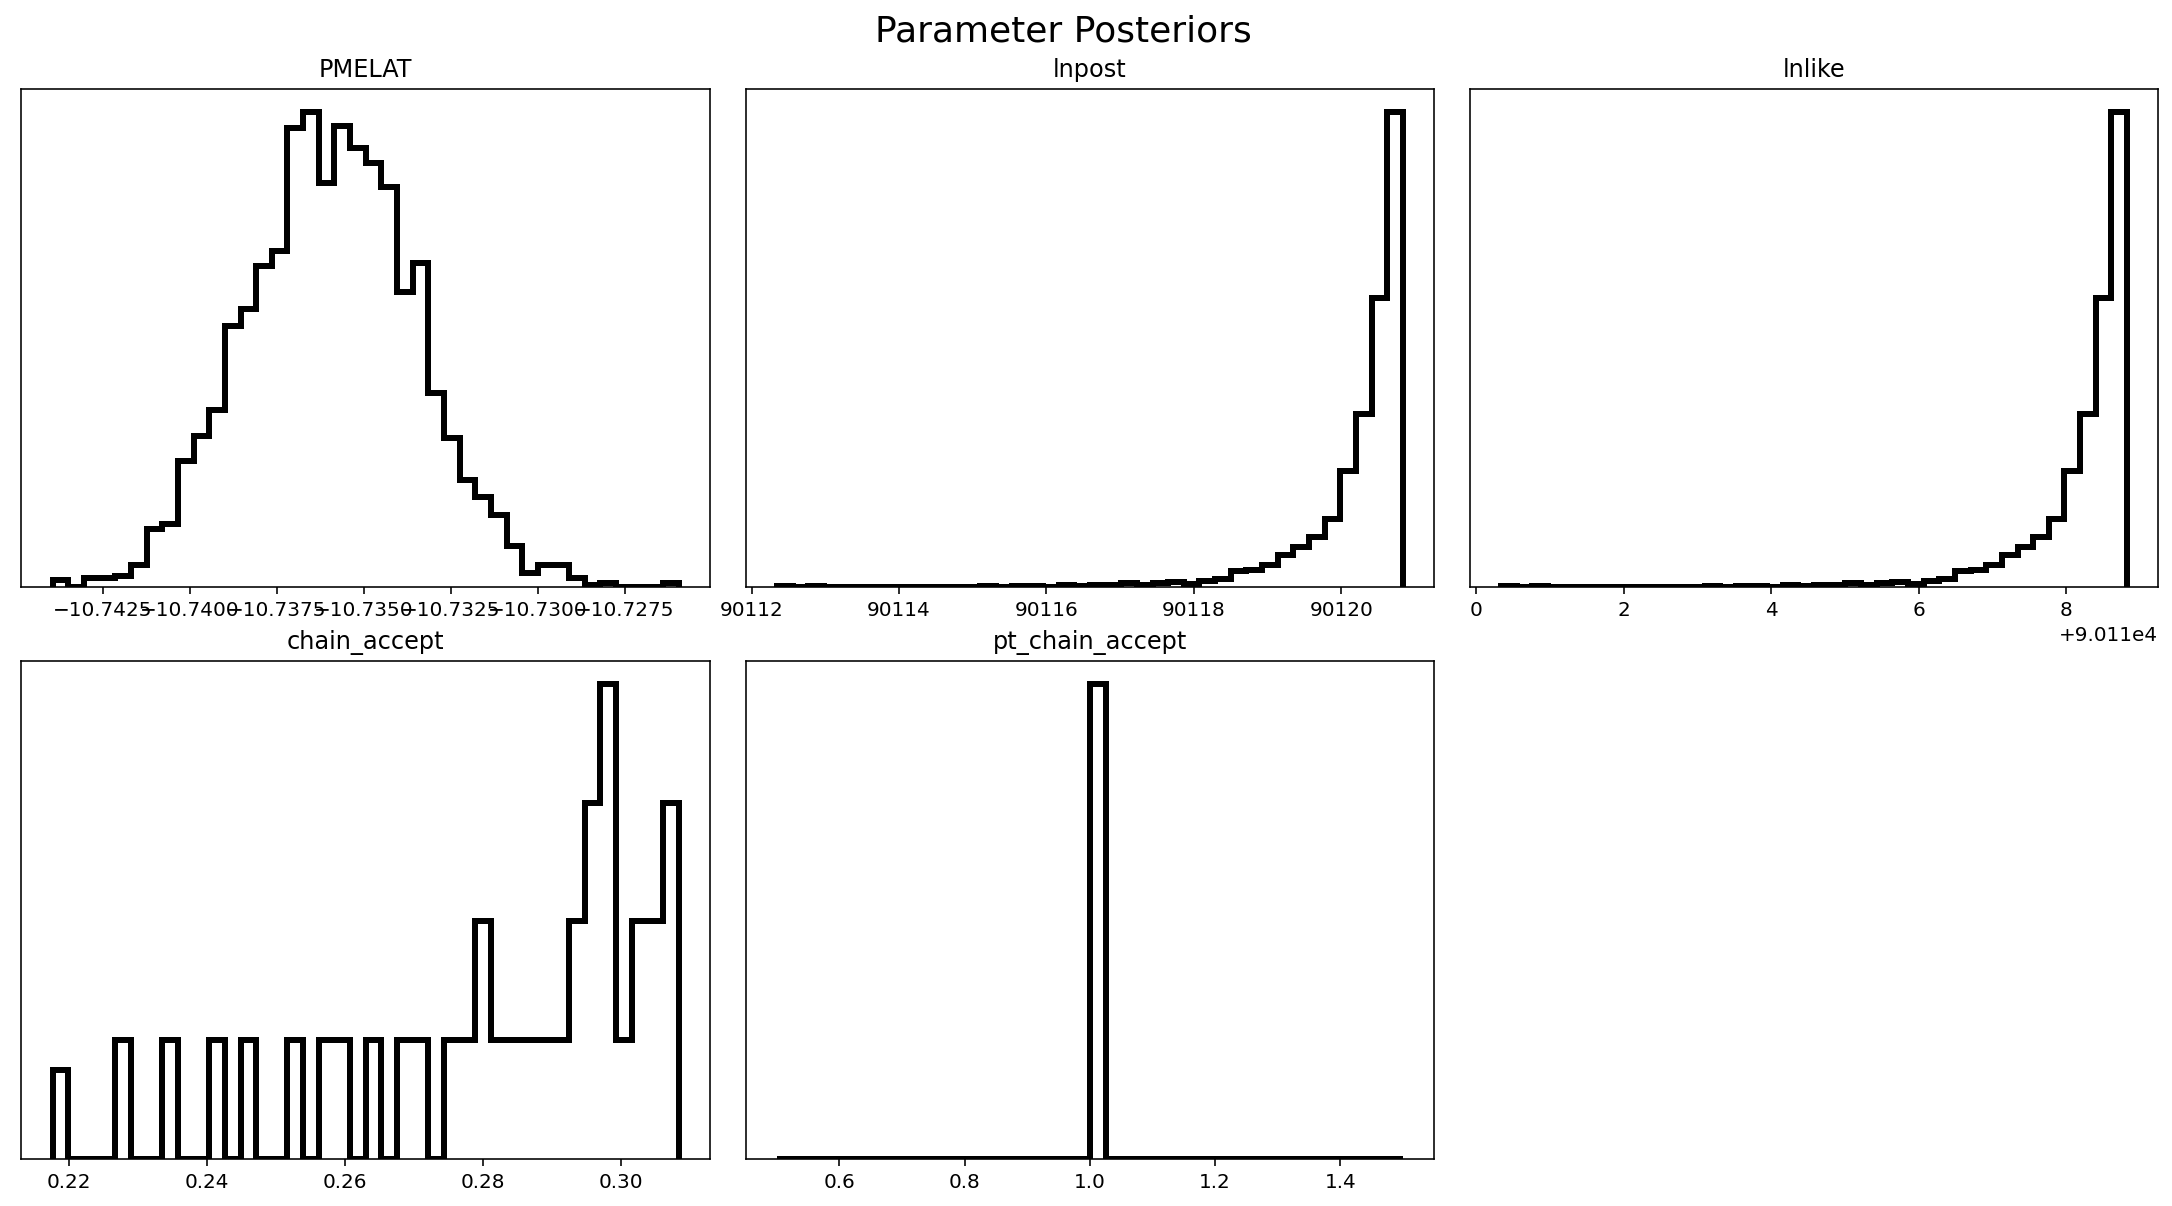

In [25]:
hist_core_kwargs = {'hist':True, 'ncols':3,'title_y':1.03,
                'hist_kwargs':dict(fill=False),'linewidth':3.}
trace_core_kwargs = {'hist':False, 'ncols':3,'title_y':1.01,
                'hist_kwargs':dict(fill=False),'linewidth':3.}
dg.plot_chains(timing_core,
               pars=timing_core.params,
               real_tm_pars=False,
               **trace_core_kwargs)
dg.plot_chains(timing_core,
               pars=timing_core.params,
               real_tm_pars=False,
               **hist_core_kwargs)

hist_kwargs = {'fill':False,'density':True}
plt.hist(np.sqrt(1.-timing_core.get_param(grid_param)**2),**hist_kwargs);
plt.show()
plt.hist(core_PAL2_fonseca.get_param('J1640+2224_timing_model_SINI'),**hist_kwargs);
plt.show()

In [26]:
map_dict_F16

{'J1640+2224_timing_model_PMELONG': 4.17885496346163,
 'J1640+2224_timing_model_PMELAT': -10.734669214940189,
 'J1640+2224_timing_model_PX': 0.790742108058695,
 'J1640+2224_timing_model_SINI': 0.9010212719777996,
 'J1640+2224_timing_model_PB': 175.46066189946055,
 'J1640+2224_timing_model_T0': 55661.77428136889,
 'J1640+2224_timing_model_A1': 55.32972036996697,
 'J1640+2224_timing_model_OM': 50.73190910865213,
 'J1640+2224_timing_model_ECC': 0.0007972687644447,
 'J1640+2224_timing_model_XDOT': 1.15e-14,
 'J1640+2224_timing_model_M2': 0.3697595648851652}

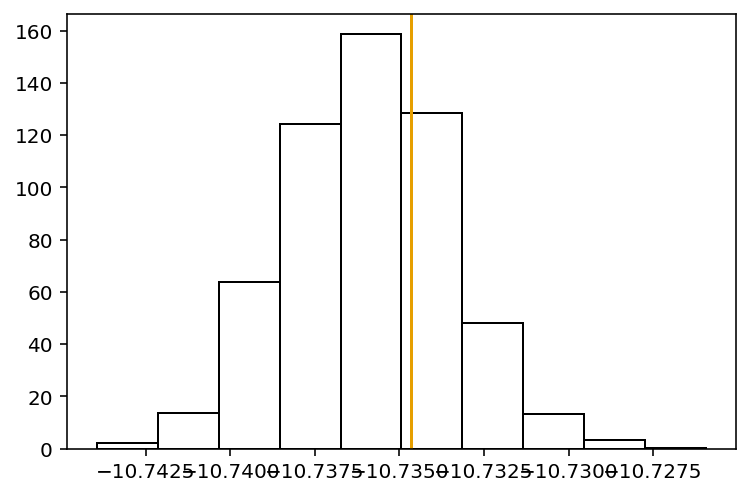

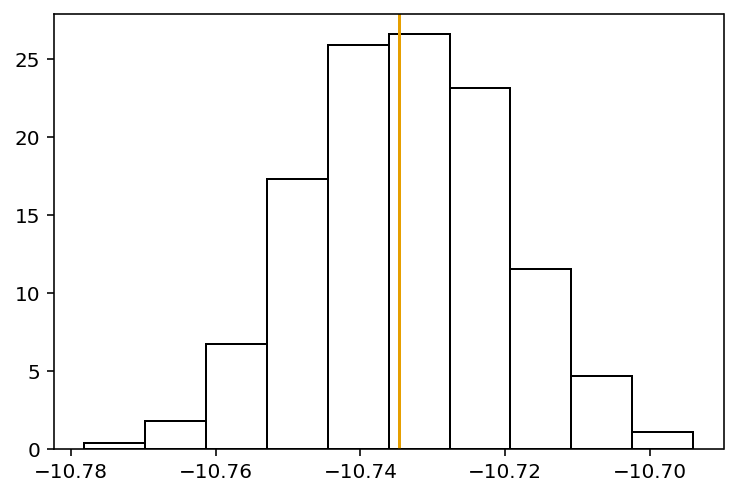

In [27]:
hist_kwargs = {'fill':False,'density':True}
plt.hist(timing_core.get_param(grid_param),**hist_kwargs);
plt.axvline(map_dict_F16['J1640+2224_timing_model_'+ grid_param],color='C1')
plt.show()
plt.hist(core_PAL2_fonseca.get_param('J1640+2224_timing_model_'+ grid_param),**hist_kwargs);
plt.axvline(map_dict_F16['J1640+2224_timing_model_'+ grid_param],color='C1')
plt.show()

No burn specified. Burn set to 25% of chain length, 2700
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
----------------
COSI


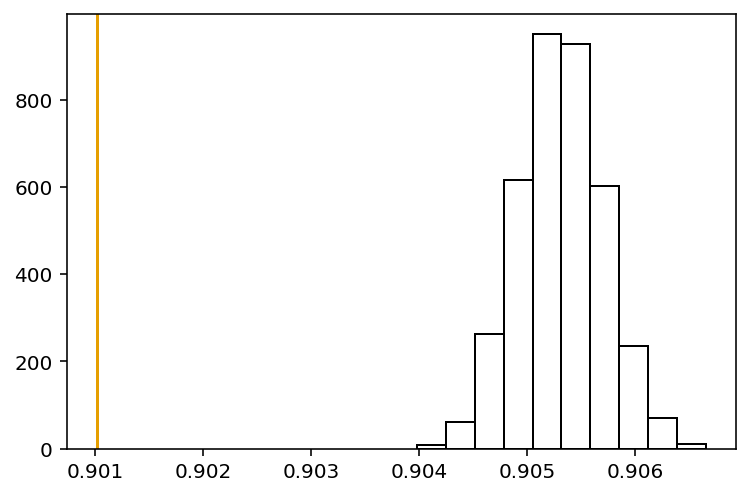

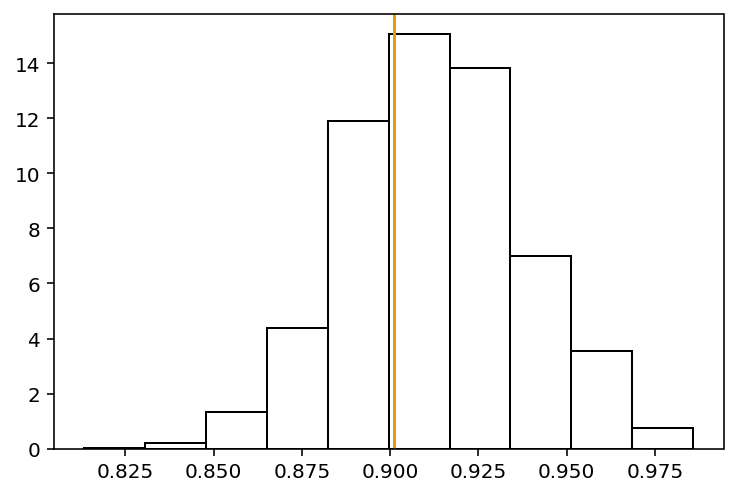

No burn specified. Burn set to 25% of chain length, 2475
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
----------------
M2


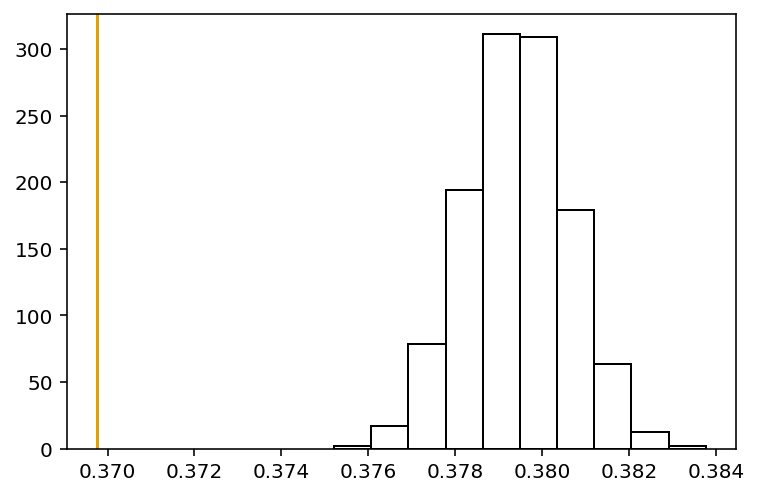

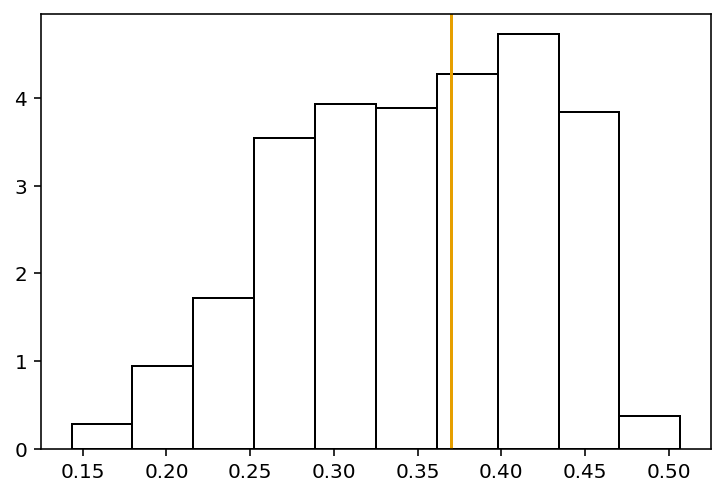

No burn specified. Burn set to 25% of chain length, 1225
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
----------------
PMELONG


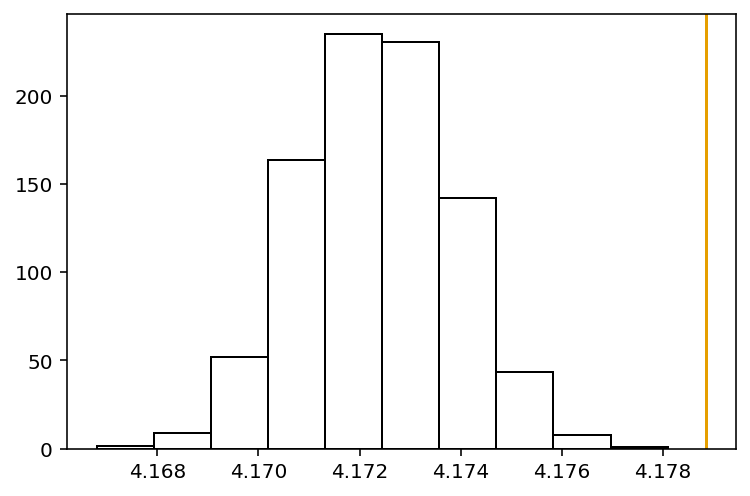

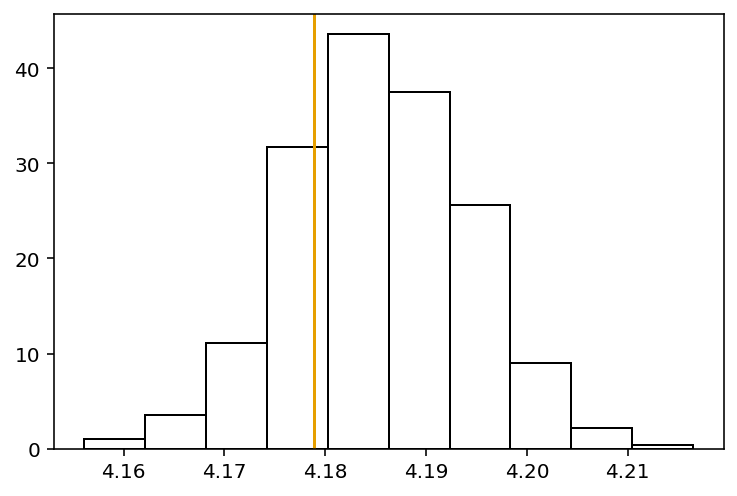

No burn specified. Burn set to 25% of chain length, 1225
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
----------------
PMELAT


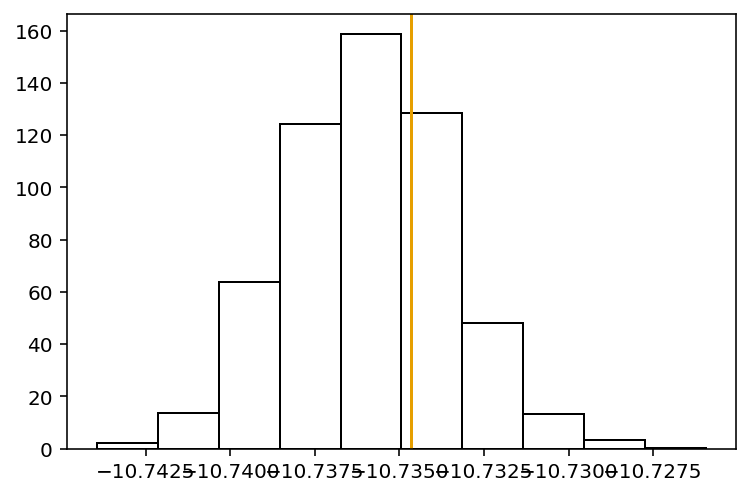

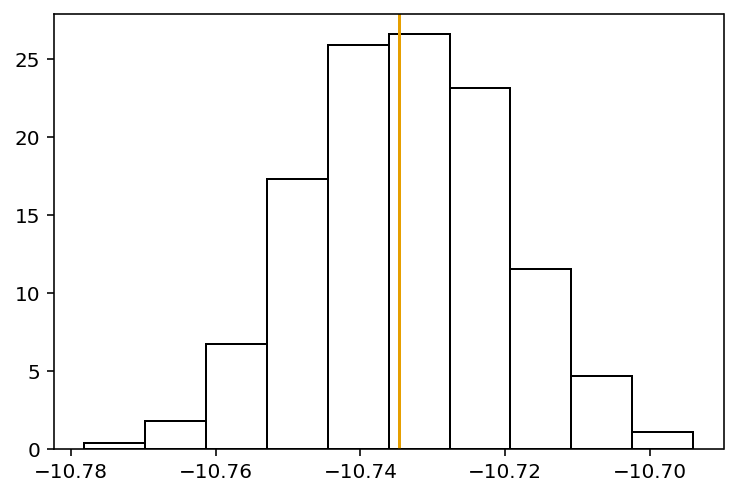

In [37]:
for fgrp in fin_grid_params:
    burn = None
    tmp_outdir = current_path + f'/{psr.name}/chains/nltm_gridding/nltm_gridding_{fgrp}'
    tmp_timing_chain = pd.read_csv(tmp_outdir+'/chain_1.txt', sep='\t', dtype=float, header=None).values
    tmp_timing_core = TimingCore(fgrp,chain=tmp_timing_chain,params=[fgrp]+exclude_list,
                             tm_pars_path=outdir+'/orig_timing_pars.pkl',
                             burn=burn)
    print('----------------')
    print(fgrp)
    hist_kwargs = {'fill':False,'density':True}
    if fgrp == 'COSI':
        plt.hist(np.sqrt(1.-tmp_timing_core.get_param(fgrp)**2),**hist_kwargs);
        plt.axvline(map_dict_F16['J1640+2224_timing_model_SINI'],color='C1')
    else:
        plt.hist(tmp_timing_core.get_param(fgrp),**hist_kwargs);
        plt.axvline(map_dict_F16['J1640+2224_timing_model_'+ fgrp],color='C1')
    plt.show()
    if fgrp == 'COSI':
        plt.hist(core_PAL2_fonseca.get_param('J1640+2224_timing_model_SINI'),**hist_kwargs);
        plt.axvline(map_dict_F16['J1640+2224_timing_model_SINI'],color='C1')
    else:
        plt.hist(core_PAL2_fonseca.get_param('J1640+2224_timing_model_'+ fgrp),**hist_kwargs);
        plt.axvline(map_dict_F16['J1640+2224_timing_model_'+ fgrp],color='C1')
    plt.show()